In [1]:
# MLB Batting Analysis System
# A comprehensive tool for analyzing baseball batting statistics across all seasons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data and setup
df = pd.read_csv('batting_all_seasons.csv')
plt.style.use('default')
sns.set_palette("Set2")

# Add a message about seasons at startup
seasons_range = f"{df['Season'].min()}-{df['Season'].max()}"
seasons_count = df['Season'].nunique()
seasons_list = sorted(df['Season'].unique())

print("MLB Batting Analysis System")
print("="*60)
print(f"Loaded {len(df):,} player records from {seasons_range}")
print(f"Analyzing {seasons_count} seasons: {', '.join(map(str, seasons_list))}")
print(f"{df['player_name'].nunique():,} unique players available for analysis")

# =============================================================================
# 1. PLAYER SEARCH AND OVERVIEW
# =============================================================================

def search_players(name_pattern):
    """Search for players by name pattern"""
    matches = df[df['player_name'].str.contains(name_pattern, case=False, na=False)]['player_name'].unique()
    print(f"Found {len(matches)} players matching '{name_pattern}':")
    for i, player in enumerate(sorted(matches), 1):
        # Add seasons played information
        player_seasons = sorted(df[df['player_name'] == player]['Season'].unique())
        seasons_str = f"{player_seasons[0]}-{player_seasons[-1]}" if len(player_seasons) > 1 else f"{player_seasons[0]}"
        print(f"  {i}. {player} ({seasons_str})")
    return sorted(matches)

def get_player_overview(player_name):
    """Get comprehensive overview of a player"""
    player_data = df[df['player_name'] == player_name].copy()
    
    if len(player_data) == 0:
        print(f"No data found for player: {player_name}")
        return None
    
    print(f"\nPLAYER OVERVIEW: {player_name}")
    print("="*60)
    
    # Basic info
    seasons = sorted(player_data['Season'].unique())
    seasons_str = ', '.join(map(str, seasons))
    teams = player_data['team'].unique()
    positions = player_data['position'].unique()
    ages = f"{player_data['age'].min()}-{player_data['age'].max()}"
    
    print(f"Seasons Played: {len(seasons)} seasons ({seasons_str})")
    print(f"Teams: {', '.join(teams)}")
    print(f"Position: {', '.join(positions)}")
    print(f"Age Range: {ages}")
    
    # Career totals and averages
    career_totals = {
        'Games': player_data['games'].sum(),
        'At Bats': player_data['at_bats'].sum(),
        'Hits': player_data['hits'].sum(),
        'Home Runs': player_data['home_runs'].sum(),
        'RBIs': player_data['runs_batted_in'].sum(),
        'Walks': player_data['walks'].sum(),
        'Stolen Bases': player_data['stolen_bases'].sum() if 'stolen_bases' in player_data.columns else 0
    }
    
    career_avgs = player_data.mean(numeric_only=True)
    
    print(f"\nCAREER TOTALS:")
    print(f"   Games: {career_totals['Games']}")
    print(f"   At Bats: {career_totals['At Bats']}")
    print(f"   Hits: {career_totals['Hits']}")
    print(f"   Home Runs: {career_totals['Home Runs']}")
    print(f"   RBIs: {career_totals['RBIs']}")
    print(f"   Walks: {career_totals['Walks']}")
    print(f"   Stolen Bases: {career_totals['Stolen Bases']}")
    
    # Career slash line and other key metrics
    ba = career_totals['Hits'] / career_totals['At Bats'] if career_totals['At Bats'] > 0 else 0
    career_ops = career_avgs['on_base_percentage'] + career_avgs['slugging_percentage']
    
    print(f"\nCAREER AVERAGES:")
    print(f"   Batting Average: {ba:.3f}")
    print(f"   On-Base %: {career_avgs['on_base_percentage']:.3f}")
    print(f"   Slugging %: {career_avgs['slugging_percentage']:.3f}")
    print(f"   OPS: {career_ops:.3f}")
    if 'WAR' in career_avgs:
        print(f"   WAR/Season: {career_avgs['WAR']:.2f}")
    
    # Display stats by season
    print(f"\nSTATS BY SEASON:")
    print(f"{'Season':<7} {'Team':<5} {'AVG':<6} {'OBP':<6} {'SLG':<6} {'HR':<4} {'RBI':<5} {'WAR':<5}")
    print("-" * 50)
    
    for _, season_row in player_data.sort_values('Season').iterrows():
        war_val = f"{season_row['WAR']:.1f}" if 'WAR' in season_row and not pd.isna(season_row['WAR']) else "N/A"
        print(f"{season_row['Season']:<7} {season_row['team']:<5} "
              f"{season_row['batting_average']:.3f} {season_row['on_base_percentage']:.3f} "
              f"{season_row['slugging_percentage']:.3f} {season_row['home_runs']:<4} "
              f"{season_row['runs_batted_in']:<5} {war_val}")
    
    # Best season
    best_season_idx = player_data['WAR'].idxmax() if 'WAR' in player_data.columns else player_data['on_base_plus_slugging'].idxmax()
    best_season = player_data.loc[best_season_idx]
    print(f"\nBEST SEASON: {best_season['Season']}")
    print(f"   Slash Line: {best_season['batting_average']:.3f}/{best_season['on_base_percentage']:.3f}/{best_season['slugging_percentage']:.3f}")
    print(f"   {best_season['home_runs']} HR, {best_season['runs_batted_in']} RBI, {best_season['runs']} Runs")
    if 'WAR' in best_season:
        print(f"   WAR: {best_season['WAR']:.1f}")
    if 'ops_plus' in best_season:
        print(f"   OPS+: {best_season['ops_plus']}")
    print(f"   Team: {best_season['team']}, Games: {best_season['games']}")
    
    # Awards and achievements
    awards_seasons = player_data[player_data['Awards'].notna()]
    if len(awards_seasons) > 0:
        print(f"\nAWARDS & ACHIEVEMENTS:")
        for _, season in awards_seasons.iterrows():
            print(f"   {season['Season']}: {season['Awards']}")
    
    return player_data

# =============================================================================
# 2. PLAYER PERFORMANCE TRENDS
# =============================================================================

def analyze_player_trends(player_name):
    """Analyze player's performance trends over time"""
    player_data = df[df['player_name'] == player_name].copy()
    
    if len(player_data) == 0:
        print(f"No data found for player: {player_name}")
        return
    
    player_data = player_data.sort_values('Season')
    
    print(f"\nPERFORMANCE TRENDS: {player_name}")
    print("="*50)
    
    # Check if player has multiple seasons for trend analysis
    if len(player_data['Season'].unique()) < 2:
        print(f"Trend analysis requires at least 2 seasons. {player_name} only has data for {player_data['Season'].iloc[0]}.")
        return
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Batting average trend
    axes[0,0].plot(player_data['Season'], player_data['batting_average'], 
                   marker='o', linewidth=2, markersize=6, color='blue')
    axes[0,0].set_title(f'{player_name} - Batting Average Trend', fontweight='bold')
    axes[0,0].set_xlabel('Season')
    axes[0,0].set_ylabel('Batting Average')
    axes[0,0].grid(True, alpha=0.3)
    
    # OBP, SLG trend
    axes[0,1].plot(player_data['Season'], player_data['on_base_percentage'], 
                   marker='s', linewidth=2, markersize=6, color='green', label='OBP')
    axes[0,1].plot(player_data['Season'], player_data['slugging_percentage'], 
                   marker='^', linewidth=2, markersize=6, color='red', label='SLG')
    axes[0,1].set_title(f'{player_name} - OBP & SLG Trends', fontweight='bold')
    axes[0,1].set_xlabel('Season')
    axes[0,1].set_ylabel('Rate')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Home runs trend
    axes[1,0].plot(player_data['Season'], player_data['home_runs'], 
                   marker='d', linewidth=2, markersize=6, color='purple')
    axes[1,0].set_title(f'{player_name} - Home Runs Trend', fontweight='bold')
    axes[1,0].set_xlabel('Season')
    axes[1,0].set_ylabel('Home Runs')
    axes[1,0].grid(True, alpha=0.3)
    
    # WAR trend or alternative
    if 'WAR' in player_data.columns and not player_data['WAR'].isna().all():
        axes[1,1].plot(player_data['Season'], player_data['WAR'], 
                       marker='o', linewidth=2, markersize=6, color='orange')
        axes[1,1].set_title(f'{player_name} - WAR Trend', fontweight='bold')
        axes[1,1].set_xlabel('Season')
        axes[1,1].set_ylabel('WAR')
        axes[1,1].grid(True, alpha=0.3)
    else:
        # RBI trend as fallback if WAR isn't available
        axes[1,1].plot(player_data['Season'], player_data['runs_batted_in'], 
                       marker='o', linewidth=2, markersize=6, color='orange')
        axes[1,1].set_title(f'{player_name} - RBI Trend', fontweight='bold')
        axes[1,1].set_xlabel('Season')
        axes[1,1].set_ylabel('RBIs')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print("TREND ANALYSIS:")
    if len(player_data) > 1:
        avg_trend = np.polyfit(player_data['Season'], player_data['batting_average'], 1)[0]
        obp_trend = np.polyfit(player_data['Season'], player_data['on_base_percentage'], 1)[0]
        slg_trend = np.polyfit(player_data['Season'], player_data['slugging_percentage'], 1)[0]
        hr_trend = np.polyfit(player_data['Season'], player_data['home_runs'], 1)[0]
        
        print(f"   Batting average trend: {avg_trend:+.4f} per season")
        print(f"   On-base % trend: {obp_trend:+.4f} per season")
        print(f"   Slugging % trend: {slg_trend:+.4f} per season")
        print(f"   Home run trend: {hr_trend:+.2f} per season")
        
        if avg_trend > 0.005:
            print("   Improving hitter (AVG)")
        elif avg_trend < -0.005:
            print("   Declining hitter (AVG)")
        else:
            print("   Consistent hitter (AVG)")

# =============================================================================
# 3. PLAYER COMPARISON
# =============================================================================

def compare_players(player1, player2):
    """Compare two players across multiple metrics"""
    p1_data = df[df['player_name'] == player1]
    p2_data = df[df['player_name'] == player2]
    
    if len(p1_data) == 0 or len(p2_data) == 0:
        print("One or both players not found")
        return
    
    print(f"\nPLAYER COMPARISON: {player1} vs {player2}")
    print("="*60)
    
    # Show seasons played for context
    p1_seasons = sorted(p1_data['Season'].unique())
    p2_seasons = sorted(p2_data['Season'].unique())
    
    print(f"{player1} seasons: {', '.join(map(str, p1_seasons))}")
    print(f"{player2} seasons: {', '.join(map(str, p2_seasons))}")
    print("")
    
    # Career averages comparison
    p1_avg = p1_data.mean(numeric_only=True)
    p2_avg = p2_data.mean(numeric_only=True)
    
    # Total stats
    p1_total = {
        'Games': p1_data['games'].sum(),
        'At Bats': p1_data['at_bats'].sum(),
        'Hits': p1_data['hits'].sum(),
        'HR': p1_data['home_runs'].sum(),
        'RBI': p1_data['runs_batted_in'].sum(),
        'Walks': p1_data['walks'].sum(),
        'SB': p1_data['stolen_bases'].sum() if 'stolen_bases' in p1_data.columns else 0
    }
    
    p2_total = {
        'Games': p2_data['games'].sum(),
        'At Bats': p2_data['at_bats'].sum(),
        'Hits': p2_data['hits'].sum(),
        'HR': p2_data['home_runs'].sum(),
        'RBI': p2_data['runs_batted_in'].sum(),
        'Walks': p2_data['walks'].sum(),
        'SB': p2_data['stolen_bases'].sum() if 'stolen_bases' in p2_data.columns else 0
    }
    
    # Calculate batting averages from totals
    p1_total['AVG'] = p1_total['Hits'] / p1_total['At Bats'] if p1_total['At Bats'] > 0 else 0
    p2_total['AVG'] = p2_total['Hits'] / p2_total['At Bats'] if p2_total['At Bats'] > 0 else 0
    
    # Comparison metrics
    avg_comparison_metrics = ['batting_average', 'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging', 'WAR']
    avg_metric_labels = ['Batting Avg', 'On-Base %', 'Slugging %', 'OPS', 'WAR/Season']
    
    # Adjust metrics if WAR is not available
    if 'WAR' not in p1_avg or 'WAR' not in p2_avg:
        avg_comparison_metrics = ['batting_average', 'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging']
        avg_metric_labels = ['Batting Avg', 'On-Base %', 'Slugging %', 'OPS']
    
    total_comparison_metrics = ['Games', 'Hits', 'HR', 'RBI', 'Walks', 'SB', 'AVG']
    
    print("CAREER TOTALS COMPARISON:")
    
    header = f"{'Metric':<15} {player1:<15} {player2:<15} {'Winner':<10}"
    print(header)
    print("-" * 65)
    
    for metric in total_comparison_metrics:
        val1 = p1_total[metric]
        val2 = p2_total[metric]
        winner = player1 if val1 > val2 else player2
        
        # Format values
        if metric == 'AVG':
            val1_str = f"{val1:.3f}"
            val2_str = f"{val2:.3f}"
        else:
            val1_str = f"{val1:.0f}"
            val2_str = f"{val2:.0f}"
        
        line = f"{metric:<15} {val1_str:<15} {val2_str:<15} {winner:<10}"
        print(line)
    
    print("\nCAREER AVERAGES COMPARISON:")
    
    header = f"{'Metric':<15} {player1:<15} {player2:<15} {'Winner':<10}"
    print(header)
    print("-" * 65)
    
    for i, metric in enumerate(avg_comparison_metrics):
        if metric in p1_avg and metric in p2_avg:
            val1 = p1_avg[metric]
            val2 = p2_avg[metric]
            winner = player1 if val1 > val2 else player2
            
            # Format values based on type
            if metric in ['batting_average', 'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging']:
                val1_str = f"{val1:.3f}"
                val2_str = f"{val2:.3f}"
            else:
                val1_str = f"{val1:.2f}"
                val2_str = f"{val2:.2f}"
            
            line = f"{avg_metric_labels[i]:<15} {val1_str:<15} {val2_str:<15} {winner:<10}"
            print(line)
    
    # Visual comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Performance comparison chart
    metrics_for_chart = ['batting_average', 'on_base_percentage', 'slugging_percentage', 'WAR']
    labels = ['Batting Avg', 'On-Base %', 'Slugging %', 'WAR']
    
    if 'WAR' not in p1_avg or 'WAR' not in p2_avg:
        metrics_for_chart = ['batting_average', 'on_base_percentage', 'slugging_percentage']
        labels = ['Batting Avg', 'On-Base %', 'Slugging %']
    
    p1_values = []
    p2_values = []
    
    for metric in metrics_for_chart:
        if metric in p1_avg and metric in p2_avg:
            p1_values.append(p1_avg[metric])
            p2_values.append(p2_avg[metric])
    
    # Normalize values for comparison (scale to 0-1)
    max_values = [max(p1_values[i], p2_values[i]) for i in range(len(p1_values))]
    p1_norm = [p1_values[i] / max_values[i] for i in range(len(p1_values))]
    p2_norm = [p2_values[i] / max_values[i] for i in range(len(p1_values))]
    
    x = range(len(p1_values))
    width = 0.35
    
    axes[0].bar([i - width/2 for i in x], p1_norm, width, label=player1, alpha=0.8)
    axes[0].bar([i + width/2 for i in x], p2_norm, width, label=player2, alpha=0.8)
    axes[0].set_xlabel('Metrics')
    axes[0].set_ylabel('Normalized Value')
    axes[0].set_title('Performance Comparison (Normalized)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(labels[:len(p1_values)])
    axes[0].legend()
    
    # Head-to-head timeline for home runs
    common_seasons = set(p1_data['Season']).intersection(set(p2_data['Season']))
    if len(common_seasons) > 0:
        common_seasons = sorted(common_seasons)
        p1_timeline = []
        p2_timeline = []
        
        for season in common_seasons:
            p1_season = p1_data[p1_data['Season'] == season]
            p2_season = p2_data[p2_data['Season'] == season]
            if len(p1_season) > 0 and len(p2_season) > 0:
                p1_timeline.append(p1_season['home_runs'].iloc[0])
                p2_timeline.append(p2_season['home_runs'].iloc[0])
        
        if len(p1_timeline) > 0:
            axes[1].plot(common_seasons, p1_timeline, marker='o', label=player1, linewidth=2)
            axes[1].plot(common_seasons, p2_timeline, marker='s', label=player2, linewidth=2)
            axes[1].set_xlabel('Season')
            axes[1].set_ylabel('Home Runs')
            axes[1].set_title('Home Runs Head-to-Head Timeline')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No overlapping seasons for direct comparison', 
                    horizontalalignment='center', verticalalignment='center',
                    transform=axes[1].transAxes)
    
    plt.tight_layout()
    plt.show()

# =============================================================================
# 4. PLAYER RANKINGS AND PERCENTILES
# =============================================================================

def get_player_rankings(player_name, season=None):
    """Get player's rankings and percentiles among all players"""
    if season:
        if season not in df['Season'].unique():
            print(f"No data found for season: {season}")
            available_seasons = sorted(df['Season'].unique())
            print(f"Available seasons: {', '.join(map(str, available_seasons))}")
            return
            
        season_data = df[df['Season'] == season].copy()
        player_data = season_data[season_data['player_name'] == player_name]
        print(f"\nPLAYER RANKINGS: {player_name} ({season} Season)")
    else:
        # Use career averages
        career_avgs = df.groupby('player_name').mean(numeric_only=True).reset_index()
        player_data = career_avgs[career_avgs['player_name'] == player_name]
        season_data = career_avgs
        print(f"\nPLAYER RANKINGS: {player_name} (Career Average)")
    
    if len(player_data) == 0:
        print(f"No data found for player: {player_name}")
        return
    
    print("="*50)
    
    # Ranking metrics
    ranking_metrics = ['batting_average', 'on_base_percentage', 'slugging_percentage', 'WAR']
    ranking_labels = ['Batting Avg', 'On-Base %', 'Slugging %', 'WAR']
    
    if 'WAR' not in player_data.columns:
        ranking_metrics = ['batting_average', 'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging']
        ranking_labels = ['Batting Avg', 'On-Base %', 'Slugging %', 'OPS']
    
    print("Metric       Value      Rank     Percentile   Rating")
    print("-" * 60)
    
    for i, metric in enumerate(ranking_metrics):
        if metric in player_data.columns and not pd.isna(player_data[metric].iloc[0]):
            player_value = player_data[metric].iloc[0]
            
            # Calculate rank and percentile
            metric_data = season_data[metric].dropna().sort_values(ascending=False)
            rank = (metric_data > player_value).sum() + 1
            percentile = ((len(metric_data) - rank + 1) / len(metric_data)) * 100
            
            # Rating system
            if percentile >= 95:
                rating = "Elite"
            elif percentile >= 85:
                rating = "All-Star"
            elif percentile >= 75:
                rating = "Very Good"
            elif percentile >= 50:
                rating = "Above Avg"
            elif percentile >= 25:
                rating = "Average"
            else:
                rating = "Below Avg"
            
            # Format values
            if metric in ['batting_average', 'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging']:
                value_str = f"{player_value:.3f}"
            else:
                value_str = f"{player_value:.2f}"
            
            print(f"{ranking_labels[i]:<12} {value_str:<10} {rank:<8} {percentile:.1f}%       {rating}")
        else:
            print(f"{ranking_labels[i]:<12} {'N/A':<10} {'N/A':<8} {'N/A':<11}   {'N/A'}")

# =============================================================================
# 5. ADVANCED PLAYER ANALYSIS
# =============================================================================

def advanced_player_analysis(player_name):
    """Comprehensive advanced analysis of a player"""
    player_data = df[df['player_name'] == player_name].copy()
    
    if len(player_data) == 0:
        print(f"No data found for player: {player_name}")
        return
    
    print(f"\nADVANCED ANALYSIS: {player_name}")
    print("="*50)
    
    # Power metrics
    print(f"\nPOWER METRICS:")
    player_data['ISO'] = player_data['slugging_percentage'] - player_data['batting_average']  # Isolated Power
    player_data['HR_Rate'] = player_data['home_runs'] / player_data['at_bats']
    player_data['XBH'] = player_data['doubles'] + player_data['triples'] + player_data['home_runs']
    player_data['XBH_Rate'] = player_data['XBH'] / player_data['at_bats']
    
    avg_iso = player_data['ISO'].mean()
    avg_hr_rate = player_data['HR_Rate'].mean()
    avg_xbh_rate = player_data['XBH_Rate'].mean()
    
    print(f"   Isolated Power (ISO): {avg_iso:.3f}")
    print(f"   HR per AB: {avg_hr_rate:.3f}")
    print(f"   Extra-Base Hit Rate: {avg_xbh_rate:.3f}")
    
    if avg_iso > 0.200:
        print("   Elite power hitter")
    elif avg_iso > 0.150:
        print("   Above-average power")
    elif avg_iso > 0.100:
        print("   Average power")
    else:
        print("   Below-average power")
    
    # Plate discipline analysis
    player_data['BB_Rate'] = player_data['walks'] / player_data['plate_appearances']
    player_data['K_Rate'] = player_data['strikeouts'] / player_data['plate_appearances']
    player_data['BB_K_Ratio'] = player_data['walks'] / player_data['strikeouts'].replace(0, 0.5)  # Avoid div by zero
    
    avg_bb_rate = player_data['BB_Rate'].mean()
    avg_k_rate = player_data['K_Rate'].mean()
    avg_bb_k = player_data['BB_K_Ratio'].mean()
    
    print(f"\nPLATE DISCIPLINE:")
    print(f"   Walk Rate: {avg_bb_rate:.3f}")
    print(f"   Strikeout Rate: {avg_k_rate:.3f}")
    print(f"   BB/K Ratio: {avg_bb_k:.2f}")
    
    if avg_bb_rate > 0.100:
        print("   Excellent plate discipline")
    elif avg_bb_rate > 0.080:
        print("   Good plate discipline")
    else:
        print("   Average or below plate discipline")
    
    # Consistency analysis
    # Calculate season-to-season consistency
    if len(player_data) > 1:
        avg_std = player_data['batting_average'].std()
        avg_cv = avg_std / player_data['batting_average'].mean() if player_data['batting_average'].mean() > 0 else 0
        
        print(f"\nCONSISTENCY ANALYSIS:")
        print(f"   Batting average standard deviation: {avg_std:.3f}")
        print(f"   Coefficient of variation: {avg_cv:.3f}")
        
        if avg_cv < 0.10:
            print("   Very consistent hitter")
        elif avg_cv < 0.15:
            print("   Reasonably consistent")
        else:
            print("   Inconsistent performance")
    else:
        print(f"\nCONSISTENCY ANALYSIS:")
        print(f"   Insufficient data - player has only one season")
    
    # Baserunning
    if 'stolen_bases' in player_data.columns and 'caught_stealing' in player_data.columns:
        sb_total = player_data['stolen_bases'].sum()
        cs_total = player_data['caught_stealing'].sum()
        sb_success = sb_total / (sb_total + cs_total) if (sb_total + cs_total) > 0 else 0
        
        print(f"\nBASERUNNING:")
        print(f"   SB Success Rate: {sb_success:.3f}")
        print(f"   SB per Game: {player_data['stolen_bases'].sum() / player_data['games'].sum():.3f}")
        
        if sb_success > 0.80 and sb_total > 10:
            print("   Efficient base stealer")
        elif sb_success > 0.70 and sb_total > 5:
            print("   Average base stealer")
        elif sb_total < 5:
            print("   Not a significant stolen base threat")
    
    # Age curve analysis
    if len(player_data) > 2:
        print(f"\nAGE CURVE ANALYSIS:")
        age_performance = player_data.groupby('age')[['batting_average', 'on_base_percentage', 'slugging_percentage', 'home_runs']].mean()
        
        if len(age_performance) > 1:
            peak_age_avg = age_performance['batting_average'].idxmax()
            peak_age_slg = age_performance['slugging_percentage'].idxmax()
            
            print(f"   Peak AVG age: {peak_age_avg} ({age_performance.loc[peak_age_avg, 'batting_average']:.3f})")
            print(f"   Peak SLG age: {peak_age_slg} ({age_performance.loc[peak_age_slg, 'slugging_percentage']:.3f})")
            
            # Show age progression
            print("\n   AGE PROGRESSION:")
            print(f"   {'Age':<5} {'AVG':<7} {'OBP':<7} {'SLG':<7} {'HR':<5}")
            print("   " + "-" * 30)
            for age, stats in age_performance.iterrows():
                print(f"   {age:<5} {stats['batting_average']:.3f}  {stats['on_base_percentage']:.3f}  {stats['slugging_percentage']:.3f}  {stats['home_runs']:.1f}")
    
    # Season by season advanced metrics
    print(f"\nADVANCED METRICS BY SEASON:")
    print(f"{'Season':<7} {'ISO':<6} {'BB%':<6} {'K%':<6} {'BB/K':<6} {'HR%':<6}")
    print("-" * 45)
    
    for _, season_row in player_data.sort_values('Season').iterrows():
        iso = season_row['slugging_percentage'] - season_row['batting_average']
        bb_pct = season_row['walks'] / season_row['plate_appearances'] * 100
        k_pct = season_row['strikeouts'] / season_row['plate_appearances'] * 100
        bb_k = season_row['walks'] / season_row['strikeouts'] if season_row['strikeouts'] > 0 else float('inf')
        hr_pct = season_row['home_runs'] / season_row['at_bats'] * 100
        
        bb_k_str = f"{bb_k:.2f}" if bb_k != float('inf') else "∞"
        
        print(f"{season_row['Season']:<7} {iso:.3f}  {bb_pct:.1f}%  {k_pct:.1f}%  {bb_k_str:<6} {hr_pct:.1f}%")

# =============================================================================
# 6. ONE-CLICK COMPLETE ANALYSIS
# =============================================================================

def quick_player_analysis(player_name):
    """Run complete analysis for a player with one function"""
    print(f"\nCOMPLETE ANALYSIS: {player_name}")
    print("="*60)
    
    # 1. Overview
    player_data = get_player_overview(player_name)
    if player_data is None:
        return
    
    # 2. Trends
    analyze_player_trends(player_name)
    
    # 3. Rankings  
    get_player_rankings(player_name)
    
    # 4. Advanced analysis
    advanced_player_analysis(player_name)
    
    print(f"\nComplete analysis finished for {player_name}!")

# =============================================================================
# 7. TEAM ANALYSIS
# =============================================================================

def analyze_team_batting(team_name, season=None):
    """Analyze a team's batting performance"""
    if season:
        if season not in df['Season'].unique():
            print(f"No data found for season: {season}")
            available_seasons = sorted(df['Season'].unique())
            print(f"Available seasons: {', '.join(map(str, available_seasons))}")
            return
            
        team_data = df[(df['team'] == team_name) & (df['Season'] == season)].copy()
        print(f"\nTEAM BATTING ANALYSIS: {team_name} ({season} Season)")
    else:
        team_data = df[df['team'] == team_name].copy()
        print(f"\nTEAM BATTING ANALYSIS: {team_name} (All Available Seasons)")
    
    if len(team_data) == 0:
        print(f"No data found for team: {team_name}")
        available_teams = sorted(df['team'].unique())
        print(f"Available teams: {', '.join(available_teams)}")
        return
    
    print("="*60)
    
    # Show which seasons are covered
    team_seasons = sorted(team_data['Season'].unique())
    print(f"Seasons covered: {', '.join(map(str, team_seasons))}")
    
    # Overall team stats by season
    team_by_season = team_data.groupby('Season').agg({
        'at_bats': 'sum',
        'hits': 'sum',
        'home_runs': 'sum',
        'runs_batted_in': 'sum',
        'walks': 'sum',
        'strikeouts': 'sum'
    }).reset_index()
    
    # Calculate team batting average by season
    team_by_season['team_avg'] = team_by_season['hits'] / team_by_season['at_bats']
    team_by_season['team_obp'] = team_data.groupby('Season')['on_base_percentage'].mean()
    team_by_season['team_slg'] = team_data.groupby('Season')['slugging_percentage'].mean()
    
    print("\nBATTING PERFORMANCE BY SEASON:")
    print(f"{'Season':<7} {'AVG':<6} {'OBP':<6} {'SLG':<6} {'HR':<5} {'RBI':<5} {'BB':<5} {'K':<5}")
    print("-" * 50)
    for _, row in team_by_season.iterrows():
        print(f"{row['Season']:<7} {row['team_avg']:.3f} {row['team_obp']:.3f} {row['team_slg']:.3f} " +
              f"{row['home_runs']:<5.0f} {row['runs_batted_in']:<5.0f} {row['walks']:<5.0f} {row['strikeouts']:<5.0f}")
    
    # Top hitters for the team
    top_hitters = team_data.groupby('player_name').agg({
        'hits': 'sum',
        'home_runs': 'sum',
        'runs_batted_in': 'sum',
        'at_bats': 'sum'
    })
    
    # Calculate batting average
    top_hitters['batting_avg'] = top_hitters['hits'] / top_hitters['at_bats']
    top_hitters = top_hitters.sort_values('batting_avg', ascending=False).head(5)
    
    print("\nTOP 5 HITTERS BY AVERAGE (min 100 AB):")
    for player, stats in top_hitters.iterrows():
        if stats['at_bats'] >= 100:
            print(f"   {player}: {stats['batting_avg']:.3f}, {stats['home_runs']:.0f} HR, {stats['runs_batted_in']:.0f} RBI")
    
    # Top power hitters
    top_power = team_data.groupby('player_name').agg({
        'home_runs': 'sum',
        'runs_batted_in': 'sum',
        'at_bats': 'sum'
    }).sort_values('home_runs', ascending=False).head(5)
    
    print("\nTOP 5 POWER HITTERS:")
    for player, stats in top_power.iterrows():
        hr_pct = stats['home_runs']/stats['at_bats']*100 if stats['at_bats'] > 0 else 0
        print(f"   {player}: {stats['home_runs']:.0f} HR, {stats['runs_batted_in']:.0f} RBI, {hr_pct:.1f} HR%")
    
    # Visualization of team batting over time
    if len(team_by_season) > 1:
        plt.figure(figsize=(12, 6))
        plt.plot(team_by_season['Season'], team_by_season['team_avg'], marker='o', linewidth=2, color='blue')
        plt.title(f'{team_name} - Team Batting Average by Season', fontweight='bold')
        plt.xlabel('Season')
        plt.ylabel('Batting Average')
        plt.grid(True, alpha=0.3)
        plt.show()

# =============================================================================
# 8. POSITION ANALYSIS
# =============================================================================

def position_analysis(position_code=None, season=None):
    """Analyze performance by position"""
    if position_code:
        # Check if position exists
        if position_code not in df['position'].unique():
            print(f"Position '{position_code}' not found in data.")
            available_positions = sorted(df['position'].unique())
            print(f"Available positions: {', '.join(available_positions)}")
            return
            
        pos_data = df[df['position'] == position_code].copy()
        print(f"\nPOSITION ANALYSIS: {position_code}")
    else:
        pos_data = df.copy()
        print("\nALL POSITIONS ANALYSIS")
    
    if season:
        if season not in df['Season'].unique():
            print(f"No data found for season: {season}")
            available_seasons = sorted(df['Season'].unique())
            print(f"Available seasons: {', '.join(map(str, available_seasons))}")
            return
            
        pos_data = pos_data[pos_data['Season'] == season]
        print(f"(For {season} Season)")
    else:
        print("(All Available Seasons)")
    
    if len(pos_data) == 0:
        print("No data found")
        return
    
    print("="*60)
    
    # Show seasons covered
    pos_seasons = sorted(pos_data['Season'].unique())
    print(f"Seasons covered: {', '.join(map(str, pos_seasons))}")
    
    # Position breakdown
    if not position_code:
        pos_counts = df['position'].value_counts()
        print("\nPOSITION DISTRIBUTION:")
        for pos, count in pos_counts.items():
            print(f"   {pos}: {count} records")
    
    # Performance by position
    pos_stats = pos_data.groupby('position').agg({
        'batting_average': 'mean',
        'on_base_percentage': 'mean',
        'slugging_percentage': 'mean',
        'home_runs': 'mean',
        'WAR': 'mean'
    })
    
    print("\nPERFORMANCE BY POSITION:")
    print(f"{'Position':<10} {'AVG':<8} {'OBP':<8} {'SLG':<8} {'HR/Player':<12} {'WAR/Player':<12}")
    print("-" * 60)
    for pos, row in pos_stats.iterrows():
        war_val = f"{row['WAR']:.2f}" if 'WAR' in row and not pd.isna(row['WAR']) else "N/A"
        print(f"{pos:<10} {row['batting_average']:.3f}{'':2} {row['on_base_percentage']:.3f}{'':2} {row['slugging_percentage']:.3f}{'':2} {row['home_runs']:.1f}{'':8} {war_val}")
    
    # Performance by position and season
    if not position_code and not season:
        print("\nPERFORMANCE TRENDS BY POSITION:")
        pos_season_stats = pos_data.groupby(['position', 'Season']).agg({
            'batting_average': 'mean',
            'on_base_percentage': 'mean',
            'slugging_percentage': 'mean'
        }).reset_index()
        
        # Show a few selected positions for clarity
        main_positions = ['1B', '2B', 'SS', '3B', 'OF', 'C', 'DH']
        available_positions = pos_season_stats['position'].unique()
        positions_to_show = [p for p in main_positions if p in available_positions]
        
        if len(positions_to_show) > 0:
            plt.figure(figsize=(12, 6))
            for pos in positions_to_show:
                pos_data = pos_season_stats[pos_season_stats['position'] == pos]
                plt.plot(pos_data['Season'], pos_data['batting_average'], marker='o', label=pos)
            
            plt.title('Batting Average by Position Over Time', fontweight='bold')
            plt.xlabel('Season')
            plt.ylabel('Batting Average')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()
    
    # Top performers for the position
    if position_code:
        top_position = pos_data.groupby('player_name').agg({
            'hits': 'sum',
            'home_runs': 'sum',
            'at_bats': 'sum',
            'batting_average': 'mean',
            'WAR': 'mean'
        }).sort_values('batting_average', ascending=False).head(10)
        
        print(f"\nTOP 10 {position_code} HITTERS BY AVG:")
        for player, stats in top_position.iterrows():
            war_val = f", WAR: {stats['WAR']:.2f}" if 'WAR' in stats and not pd.isna(stats['WAR']) else ""
            print(f"   {player}: {stats['batting_average']:.3f} AVG, {stats['home_runs']:.0f} HR{war_val}")
    
    # Visualization
    if not position_code and len(pos_stats) > 1:
        plt.figure(figsize=(12, 6))
        bars = plt.bar(pos_stats.index, pos_stats['slugging_percentage'])
        plt.title('Slugging Percentage by Position', fontweight='bold')
        plt.xlabel('Position')
        plt.ylabel('Slugging Percentage')
        plt.grid(True, alpha=0.3, axis='y')
        
        # Add data labels
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')
        
        plt.show()

# =============================================================================
# 9. SEASON LEADERS AND RECORDS
# =============================================================================

def season_leaders(season=None, category='batting_average'):
    """Display season leaders in a specific statistical category"""
    category_labels = {
        'batting_average': 'Batting Average',
        'home_runs': 'Home Runs',
        'runs_batted_in': 'RBIs',
        'on_base_percentage': 'On-Base Percentage',
        'slugging_percentage': 'Slugging Percentage',
        'on_base_plus_slugging': 'OPS',
        'WAR': 'WAR'
    }
    
    if category not in df.columns and category not in category_labels.keys():
        print(f"Category '{category}' not found in data.")
        available_categories = list(category_labels.keys())
        print(f"Available categories: {', '.join(available_categories)}")
        return
    
    if season:
        if season not in df['Season'].unique():
            print(f"No data found for season: {season}")
            available_seasons = sorted(df['Season'].unique())
            print(f"Available seasons: {', '.join(map(str, available_seasons))}")
            return
            
        season_data = df[df['Season'] == season].copy()
        print(f"\nSEASON LEADERS: {category_labels.get(category, category)} ({season})")
    else:
        season_data = df.copy()
        print(f"\nALL-TIME LEADERS: {category_labels.get(category, category)}")
    
    if len(season_data) == 0:
        print("No data found")
        return
    
    print("="*60)
    
    # Show seasons covered
    covered_seasons = sorted(season_data['Season'].unique())
    print(f"Seasons covered: {', '.join(map(str, covered_seasons))}")
    
    # Top performers
    # For rate stats, require minimum plate appearances
    if category in ['batting_average', 'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging']:
        # Apply minimum PA filter - typically 3.1 PAs per team game
        min_pa = 502 if season else 300  # For career stats, lower threshold
        qualified_data = season_data[season_data['plate_appearances'] >= min_pa]
        if len(qualified_data) == 0:
            # If no qualified hitters, reduce threshold
            min_pa = 300 if season else 200
            qualified_data = season_data[season_data['plate_appearances'] >= min_pa]
            print(f"Note: Using reduced qualification threshold of {min_pa} plate appearances")
        else:
            print(f"Note: Qualified hitters only (minimum {min_pa} plate appearances)")
        
        leaders = qualified_data.sort_values(category, ascending=False).head(15)
    else:
        leaders = season_data.sort_values(category, ascending=False).head(15)
    
    print(f"{'Rank':<5} {'Player':<25} {'Team':<10} {'Season':<10} {category_labels.get(category, category)}")
    print("-" * 70)
    
    for i, (_, row) in enumerate(leaders.iterrows(), 1):
        # Format value based on category
        if category in ['batting_average', 'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging']:
            value = f"{row[category]:.3f}"
        elif category == 'WAR':
            value = f"{row[category]:.2f}"
        else:
            value = f"{row[category]:.0f}"
        
        print(f"{i:<5} {row['player_name']:<25} {row['team']:<10} {row['Season']:<10} {value}")
    
    # Records analysis
    if season:
        # Compare to all-time records
        all_time_best = df[category].max()
        season_best = leaders.iloc[0][category]
        pct_of_record = (season_best / all_time_best) * 100 if all_time_best > 0 else 0
        
        print(f"\nSEASON RECORD ANALYSIS:")
        print(f"   {season} best: {season_best:.3f}" if category in ['batting_average', 'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging'] else f"   {season} best: {season_best:.0f}")
        print(f"   All-time best: {all_time_best:.3f}" if category in ['batting_average', 'on_base_percentage', 'slugging_percentage', 'on_base_plus_slugging'] else f"   All-time best: {all_time_best:.0f}")
        print(f"   {season} best is {pct_of_record:.1f}% of all-time record")
    
    # Historical trend analysis
    if not season and category in ['batting_average', 'on_base_percentage', 'slugging_percentage', 'home_runs']:
        print("\nHISTORICAL TREND ANALYSIS:")
        yearly_avg = df.groupby('Season')[category].mean().reset_index()
        yearly_max = df.groupby('Season')[category].max().reset_index()
        
        trend = np.polyfit(yearly_avg['Season'], yearly_avg[category], 1)[0]
        direction = "increasing" if trend > 0 else "decreasing"
        
        print(f"   {category_labels.get(category, category)} has been {direction} by {abs(trend):.4f} per year on average")
        
        plt.figure(figsize=(12, 6))
        plt.plot(yearly_avg['Season'], yearly_avg[category], marker='o', label='League Average')
        plt.plot(yearly_max['Season'], yearly_max[category], marker='s', label='League Best')
        plt.title(f'Historical Trend: {category_labels.get(category, category)}', fontweight='bold')
        plt.xlabel('Season')
        plt.ylabel(category_labels.get(category, category))
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# =============================================================================
# 10. CAREER PROGRESSION ANALYSIS
# =============================================================================

def analyze_career_progression(player_name):
    """Analyze how a player's career progressed over time"""
    player_data = df[df['player_name'] == player_name].copy()
    
    if len(player_data) == 0:
        print(f"No data found for player: {player_name}")
        return
    
    if len(player_data) < 3:
        print(f"Career progression analysis requires at least 3 seasons. {player_name} only has {len(player_data)} season(s).")
        return
    
    print(f"\nCAREER PROGRESSION ANALYSIS: {player_name}")
    print("="*60)
    
    # Sort by season
    player_data = player_data.sort_values('Season')
    
    # Calculate career phase indicators
    player_data['CareerYear'] = range(1, len(player_data) + 1)
    total_years = len(player_data)
    
    if total_years >= 3:
        early_years = player_data.iloc[:max(1, total_years // 3)]
        mid_years = player_data.iloc[max(1, total_years // 3):min(total_years, 2 * total_years // 3)]
        late_years = player_data.iloc[min(total_years, 2 * total_years // 3):]
        
        if len(early_years) > 0:
            print(f"Early Career ({early_years['Season'].iloc[0]}-{early_years['Season'].iloc[-1]}):")
            print(f"   AVG: {early_years['batting_average'].mean():.3f}")
            print(f"   OBP: {early_years['on_base_percentage'].mean():.3f}")
            print(f"   SLG: {early_years['slugging_percentage'].mean():.3f}")
            print(f"   HR/Season: {early_years['home_runs'].mean():.1f}")
            if 'WAR' in early_years.columns:
                print(f"   WAR/Season: {early_years['WAR'].mean():.2f}")
        
        if len(mid_years) > 0:
            print(f"\nMid Career ({mid_years['Season'].iloc[0]}-{mid_years['Season'].iloc[-1]}):")
            print(f"   AVG: {mid_years['batting_average'].mean():.3f}")
            print(f"   OBP: {mid_years['on_base_percentage'].mean():.3f}")
            print(f"   SLG: {mid_years['slugging_percentage'].mean():.3f}")
            print(f"   HR/Season: {mid_years['home_runs'].mean():.1f}")
            if 'WAR' in mid_years.columns:
                print(f"   WAR/Season: {mid_years['WAR'].mean():.2f}")
        
        if len(late_years) > 0:
            print(f"\nLate Career ({late_years['Season'].iloc[0]}-{late_years['Season'].iloc[-1]}):")
            print(f"   AVG: {late_years['batting_average'].mean():.3f}")
            print(f"   OBP: {late_years['on_base_percentage'].mean():.3f}")
            print(f"   SLG: {late_years['slugging_percentage'].mean():.3f}")
            print(f"   HR/Season: {late_years['home_runs'].mean():.1f}")
            if 'WAR' in late_years.columns:
                print(f"   WAR/Season: {late_years['WAR'].mean():.2f}")
    
    # Career visualization
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Career OPS by year
    player_data['OPS'] = player_data['on_base_percentage'] + player_data['slugging_percentage']
    axes[0,0].plot(player_data['CareerYear'], player_data['OPS'], marker='o', linewidth=2)
    axes[0,0].set_title(f'OPS by Career Year', fontweight='bold')
    axes[0,0].set_xlabel('Career Year')
    axes[0,0].set_ylabel('OPS')
    axes[0,0].grid(True, alpha=0.3)
    
    # Add season labels to points
    for i, row in player_data.iterrows():
        axes[0,0].annotate(str(row['Season']), 
                           (row['CareerYear'], row['OPS']),
                           textcoords="offset points",
                           xytext=(0,10), 
                           ha='center')
    
    # HR by career year
    axes[0,1].plot(player_data['CareerYear'], player_data['home_runs'], marker='s', linewidth=2, color='red')
    axes[0,1].set_title(f'Home Runs by Career Year', fontweight='bold')
    axes[0,1].set_xlabel('Career Year')
    axes[0,1].set_ylabel('Home Runs')
    axes[0,1].grid(True, alpha=0.3)
    
    # Slash line components
    axes[1,0].plot(player_data['CareerYear'], player_data['batting_average'], marker='o', linewidth=2, label='AVG')
    axes[1,0].plot(player_data['CareerYear'], player_data['on_base_percentage'], marker='s', linewidth=2, label='OBP')
    axes[1,0].plot(player_data['CareerYear'], player_data['slugging_percentage'], marker='^', linewidth=2, label='SLG')
    axes[1,0].set_title(f'Slash Line by Career Year', fontweight='bold')
    axes[1,0].set_xlabel('Career Year')
    axes[1,0].set_ylabel('Rate')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # WAR by career year if available
    if 'WAR' in player_data.columns and not player_data['WAR'].isna().all():
        axes[1,1].plot(player_data['CareerYear'], player_data['WAR'], marker='d', linewidth=2, color='purple')
        axes[1,1].set_title(f'WAR by Career Year', fontweight='bold')
        axes[1,1].set_xlabel('Career Year')
        axes[1,1].set_ylabel('WAR')
        axes[1,1].grid(True, alpha=0.3)
    else:
        # RBI as alternative
        axes[1,1].plot(player_data['CareerYear'], player_data['runs_batted_in'], marker='d', linewidth=2, color='purple')
        axes[1,1].set_title(f'RBIs by Career Year', fontweight='bold')
        axes[1,1].set_xlabel('Career Year')
        axes[1,1].set_ylabel('RBIs')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Career summary
    print(f"\nCAREER SUMMARY:")
    print(f"   Career Length: {total_years} seasons")
    
    if not player_data['OPS'].isna().all():
        peak_idx = player_data['OPS'].idxmax()
        peak_season = player_data.loc[peak_idx]
        peak_year = player_data['CareerYear'].loc[peak_idx]
        print(f"   Peak Season: Year {peak_year} ({peak_season['Season']})")
        print(f"   Peak OPS: {peak_season['OPS']:.3f}")
    else:
        print("   Peak Season: Unable to determine (insufficient OPS data)")
    
    # Prime years analysis
    if total_years >= 5:
        # Use rolling 3-year OPS to find prime
        player_data['Rolling_OPS'] = player_data['OPS'].rolling(window=min(3, total_years), center=True).mean()
        
        if not player_data['Rolling_OPS'].isna().all():
            prime_idx = player_data['Rolling_OPS'].idxmax()
            prime_year = player_data['CareerYear'].loc[prime_idx]
            prime_season = player_data['Season'].loc[prime_idx]
            print(f"   Prime Years: Around Year {prime_year} ({prime_season})")
        else:
            print("   Prime Years: Unable to determine (insufficient data for rolling average)")
        
        # Development and decline rates
        early_ops = player_data['OPS'].iloc[:total_years//2].mean()
        late_ops = player_data['OPS'].iloc[total_years//2:].mean()
        
        if early_ops > late_ops:
            print(f"   Career Pattern: Early peak with {(early_ops-late_ops)/late_ops*100:.1f}% decline in latter half")
        else:
            print(f"   Career Pattern: Late bloomer with {(late_ops-early_ops)/early_ops*100:.1f}% improvement in latter half")

# =============================================================================
# 11. LEAGUE TRENDS ANALYSIS
# =============================================================================

def analyze_league_trends(start_season=None, end_season=None):
    """Analyze league-wide trends over time"""
    if start_season is not None and start_season not in df['Season'].unique():
        print(f"Start season {start_season} not found in data")
        return
        
    if end_season is not None and end_season not in df['Season'].unique():
        print(f"End season {end_season} not found in data")
        return
    
    if start_season is not None and end_season is not None and start_season > end_season:
        print(f"Start season {start_season} is after end season {end_season}")
        return
    
    # Filter data by seasons if specified
    if start_season is not None and end_season is not None:
        season_data = df[(df['Season'] >= start_season) & (df['Season'] <= end_season)]
        print(f"\nLEAGUE TRENDS ANALYSIS: {start_season}-{end_season}")
    elif start_season is not None:
        season_data = df[df['Season'] >= start_season]
        print(f"\nLEAGUE TRENDS ANALYSIS: {start_season}-{df['Season'].max()}")
    elif end_season is not None:
        season_data = df[df['Season'] <= end_season]
        print(f"\nLEAGUE TRENDS ANALYSIS: {df['Season'].min()}-{end_season}")
    else:
        season_data = df.copy()
        print(f"\nLEAGUE TRENDS ANALYSIS: {df['Season'].min()}-{df['Season'].max()}")
    
    print("="*60)
    
    # Calculate league averages by season
    league_stats = season_data.groupby('Season').agg({
        'batting_average': 'mean',
        'on_base_percentage': 'mean',
        'slugging_percentage': 'mean',
        'home_runs': 'sum',
        'strikeouts': 'sum',
        'walks': 'sum',
        'plate_appearances': 'sum'
    }).reset_index()
    
    # Calculate derived metrics
    league_stats['OPS'] = league_stats['on_base_percentage'] + league_stats['slugging_percentage']
    league_stats['K_Rate'] = league_stats['strikeouts'] / league_stats['plate_appearances']
    league_stats['BB_Rate'] = league_stats['walks'] / league_stats['plate_appearances']
    
    print("LEAGUE AVERAGES BY SEASON:")
    print(f"{'Season':<7} {'AVG':<6} {'OBP':<6} {'SLG':<6} {'OPS':<6} {'K%':<6} {'BB%':<6} {'HR':<6}")
    print("-" * 60)
    for _, row in league_stats.iterrows():
        print(f"{row['Season']:<7} {row['batting_average']:.3f} {row['on_base_percentage']:.3f} " +
              f"{row['slugging_percentage']:.3f} {row['OPS']:.3f} " +
              f"{row['K_Rate']*100:.1f}% {row['BB_Rate']*100:.1f}% {row['home_runs']:<6.0f}")
    
    # Trend analysis
    if len(league_stats) > 1:
        print("\nLEAGUE TREND ANALYSIS:")
        
        # Calculate trends
        avg_trend = np.polyfit(league_stats['Season'], league_stats['batting_average'], 1)[0]
        obp_trend = np.polyfit(league_stats['Season'], league_stats['on_base_percentage'], 1)[0]
        slg_trend = np.polyfit(league_stats['Season'], league_stats['slugging_percentage'], 1)[0]
        k_trend = np.polyfit(league_stats['Season'], league_stats['K_Rate'], 1)[0]
        bb_trend = np.polyfit(league_stats['Season'], league_stats['BB_Rate'], 1)[0]
        
        # Display trend information
        print(f"   Batting Average: {avg_trend:+.4f} per season")
        print(f"   On-Base %: {obp_trend:+.4f} per season")
        print(f"   Slugging %: {slg_trend:+.4f} per season")
        print(f"   Strikeout Rate: {k_trend*100:+.2f}% per season")
        print(f"   Walk Rate: {bb_trend*100:+.2f}% per season")
        
        # Visualize trends
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Slash line components
        axes[0,0].plot(league_stats['Season'], league_stats['batting_average'], marker='o', linewidth=2, label='AVG')
        axes[0,0].plot(league_stats['Season'], league_stats['on_base_percentage'], marker='s', linewidth=2, label='OBP')
        axes[0,0].plot(league_stats['Season'], league_stats['slugging_percentage'], marker='^', linewidth=2, label='SLG')
        axes[0,0].set_title('Batting Rates by Season', fontweight='bold')
        axes[0,0].set_xlabel('Season')
        axes[0,0].set_ylabel('Rate')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # OPS trend
        axes[0,1].plot(league_stats['Season'], league_stats['OPS'], marker='o', linewidth=2, color='purple')
        axes[0,1].set_title('OPS by Season', fontweight='bold')
        axes[0,1].set_xlabel('Season')
        axes[0,1].set_ylabel('OPS')
        axes[0,1].grid(True, alpha=0.3)
        
        # Strikeout and walk rates
        axes[1,0].plot(league_stats['Season'], league_stats['K_Rate']*100, marker='o', linewidth=2, label='K%', color='red')
        axes[1,0].plot(league_stats['Season'], league_stats['BB_Rate']*100, marker='s', linewidth=2, label='BB%', color='blue')
        axes[1,0].set_title('Strikeout and Walk Rates by Season', fontweight='bold')
        axes[1,0].set_xlabel('Season')
        axes[1,0].set_ylabel('Percentage')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Home runs
        axes[1,1].plot(league_stats['Season'], league_stats['home_runs'], marker='o', linewidth=2, color='green')
        axes[1,1].set_title('Total Home Runs by Season', fontweight='bold')
        axes[1,1].set_xlabel('Season')
        axes[1,1].set_ylabel('Home Runs')
        axes[1,1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Position-specific trends
        if len(season_data) > 0:
            print("\nPOSITION TRENDS:")
            # Select a few key positions
            key_positions = ['1B', 'SS', 'C', 'OF']
            available_positions = season_data['position'].unique()
            positions_to_analyze = [p for p in key_positions if p in available_positions]
            
            if len(positions_to_analyze) > 0:
                pos_trends = {}
                
                for pos in positions_to_analyze:
                    pos_data = season_data[season_data['position'] == pos]
                    pos_stats = pos_data.groupby('Season')['on_base_plus_slugging'].mean().reset_index()
                    
                    if len(pos_stats) > 1:
                        trend = np.polyfit(pos_stats['Season'], pos_stats['on_base_plus_slugging'], 1)[0]
                        pos_trends[pos] = trend
                
                # Display position trends
                for pos, trend in pos_trends.items():
                    print(f"   {pos}: OPS {trend:+.4f} per season")
            
                # Visualize position OPS trends
                plt.figure(figsize=(12, 6))
                for pos in positions_to_analyze:
                    pos_data = season_data[season_data['position'] == pos]
                    pos_stats = pos_data.groupby('Season')['on_base_plus_slugging'].mean().reset_index()
                    if len(pos_stats) > 1:
                        plt.plot(pos_stats['Season'], pos_stats['on_base_plus_slugging'], marker='o', linewidth=2, label=pos)
                
                plt.title('OPS by Position Over Time', fontweight='bold')
                plt.xlabel('Season')
                plt.ylabel('OPS')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.show()
    else:
        print("\nNot enough seasons for trend analysis.")

# =============================================================================
# 12. MAIN FUNCTION
# =============================================================================

def main():
    """Main interface function"""
    print("\nMLB BATTING ANALYSIS SYSTEM")
    print("="*60)
    print("Here are the available functions:")
    print()

    print("SEARCH FUNCTIONS:")
    print("search_players('partial name') - Find players by name")
    print()

    print("PLAYER ANALYSIS:")
    print("get_player_overview('player name') - Complete player profile")
    print("analyze_player_trends('player name') - Performance over time")
    print("compare_players('player1', 'player2') - Head-to-head comparison")
    print("get_player_rankings('player name', season=None) - Rankings and percentiles")
    print("advanced_player_analysis('player name') - Advanced metrics")
    print("analyze_career_progression('player name') - Career trajectory analysis")
    print("quick_player_analysis('player name') - Complete analysis")
    print()

    print("TEAM & POSITION ANALYSIS:")
    print("analyze_team_batting('team name', season=None) - Team batting analysis")
    print("position_analysis('position code', season=None) - Position breakdown")
    print("season_leaders(season=None, category='batting_average') - Season leaders in a category")
    print("analyze_league_trends(start_season=None, end_season=None) - League-wide trends")
    print()
    
    # Display available seasons
    seasons = sorted(df['Season'].unique())
    print(f"AVAILABLE SEASONS: {', '.join(map(str, seasons))}")
    
    # Display available teams
    teams = sorted(df['team'].unique())
    print(f"AVAILABLE TEAMS: {', '.join(teams)}")
    

    print("QUICK START EXAMPLES:")
    print("# Find a player:")
    print("search_players('Trout')")
    print()
    print("# Complete analysis:")
    print("quick_player_analysis('Mike Trout')")
    print()
    print("# Compare players:")
    print("compare_players('Mookie Betts', 'Aaron Judge')")
    print()
    print("# League trends:")
    print(f"analyze_league_trends({seasons[0]}, {seasons[-1]})")
    print()

    print("TOP HITTERS IN DATASET:")
    # Getting top 10 by batting average (min 500 at bats)
    qualified_hitters = df.groupby('player_name').filter(lambda x: x['at_bats'].sum() >= 500)
    top_avg = qualified_hitters.groupby('player_name')['batting_average'].mean().nlargest(10)
    for i, (player, avg) in enumerate(top_avg.items(), 1):
        print(f"{i:2d}. {player} ({avg:.3f} AVG)")

    print(f"\nTry running: quick_player_analysis('{top_avg.index[0]}')")

if __name__ == "__main__":
    main()

MLB Batting Analysis System
Loaded 1,548 player records from 2016-2024
Analyzing 9 seasons: 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024
455 unique players available for analysis

MLB BATTING ANALYSIS SYSTEM
Here are the available functions:

SEARCH FUNCTIONS:
search_players('partial name') - Find players by name

PLAYER ANALYSIS:
get_player_overview('player name') - Complete player profile
analyze_player_trends('player name') - Performance over time
compare_players('player1', 'player2') - Head-to-head comparison
get_player_rankings('player name', season=None) - Rankings and percentiles
advanced_player_analysis('player name') - Advanced metrics
analyze_career_progression('player name') - Career trajectory analysis
quick_player_analysis('player name') - Complete analysis

TEAM & POSITION ANALYSIS:
analyze_team_batting('team name', season=None) - Team batting analysis
position_analysis('position code', season=None) - Position breakdown
season_leaders(season=None, category='battin

In [2]:
search_players("Ron")

Found 6 players matching 'Ron':
  1. Aaron Hicks (2018-2020)
  2. Aaron Judge (2017-2024)
  3. Byron Buxton (2017)
  4. C.J. Cron (2018-2022)
  5. Jake Cronenworth (2020-2024)
  6. Ronald Acuña Jr. (2019-2023)


['Aaron Hicks',
 'Aaron Judge',
 'Byron Buxton',
 'C.J. Cron',
 'Jake Cronenworth',
 'Ronald Acuña Jr.']


COMPLETE ANALYSIS: Ronald Acuña Jr.

PLAYER OVERVIEW: Ronald Acuña Jr.
Seasons Played: 4 seasons (2019, 2020, 2022, 2023)
Teams: ATL
Position: *879/H, *89, 9D/H8, *9/D
Age Range: 21-25

CAREER TOTALS:
   Games: 480
   At Bats: 1896
   Hits: 556
   Home Runs: 111
   RBIs: 286
   Walks: 247
   Stolen Bases: 147

CAREER AVERAGES:
   Batting Average: 0.293
   On-Base %: 0.384
   Slugging %: 0.527
   OPS: 0.911
   WAR/Season: 4.57

STATS BY SEASON:
Season  Team  AVG    OBP    SLG    HR   RBI   WAR  
--------------------------------------------------
2019    ATL   0.280 0.365 0.518 41   101   5.2
2020    ATL   0.250 0.406 0.581 14   29    2.4
2022    ATL   0.266 0.351 0.413 15   50    2.3
2023    ATL   0.337 0.416 0.596 41   106   8.4

BEST SEASON: 2023
   Slash Line: 0.337/0.416/0.596
   41 HR, 106 RBI, 149 Runs
   WAR: 8.4
   OPS+: 171
   Team: ATL, Games: 159

AWARDS & ACHIEVEMENTS:
   2019: AS,MVP-5,SS
   2020: MVP-12,SS
   2022: AS
   2023: AS,MVP-1,SS

PERFORMANCE TRENDS: Ronald Acuña

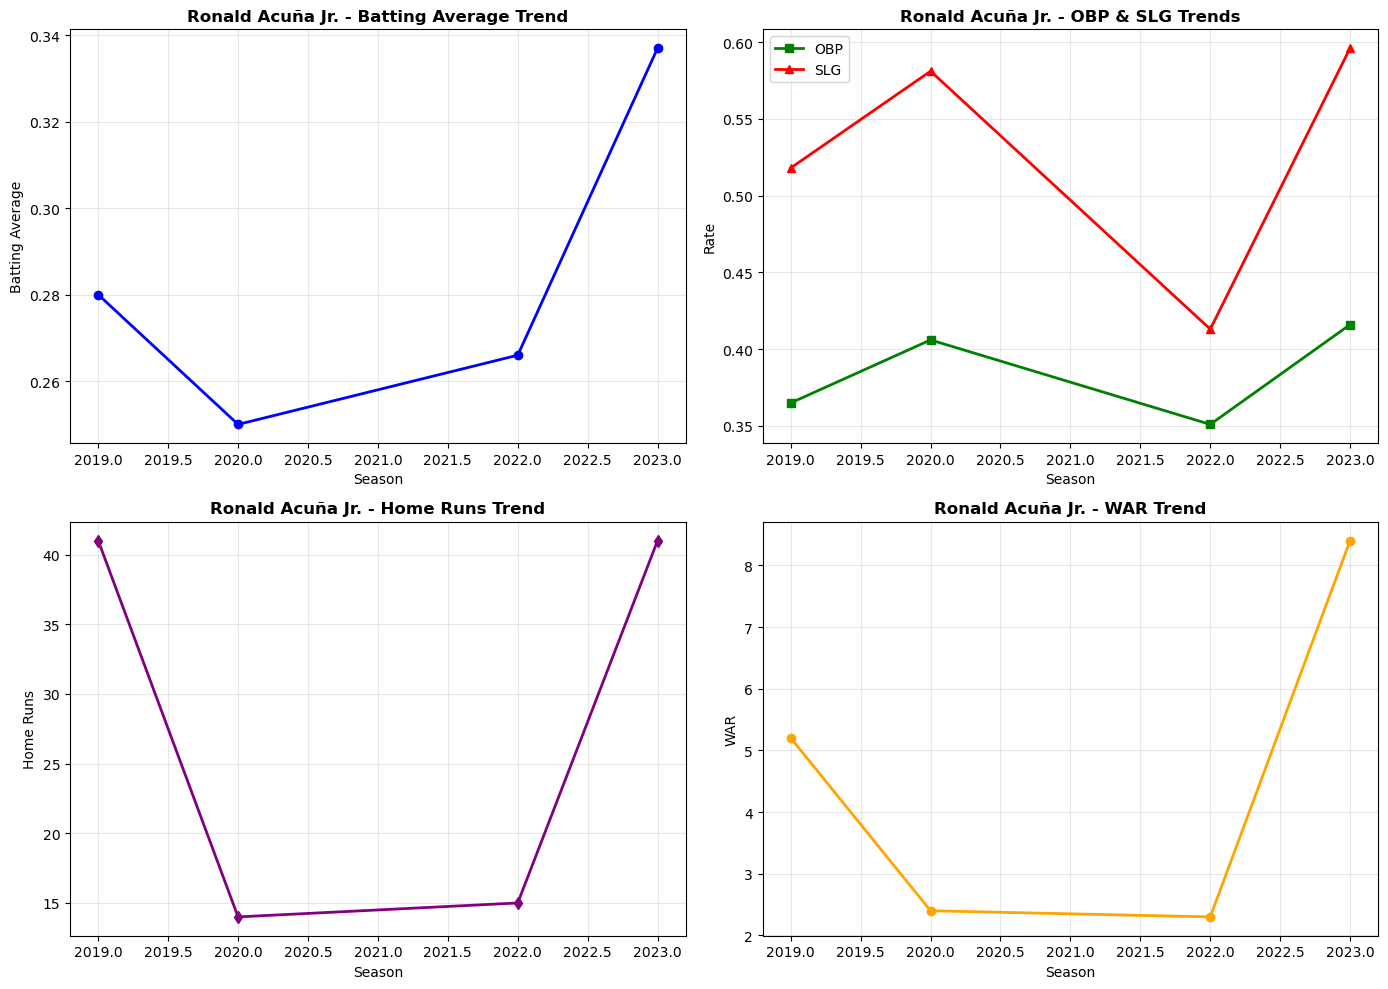

TREND ANALYSIS:
   Batting average trend: +0.0130 per season
   On-base % trend: +0.0047 per season
   Slugging % trend: -0.0012 per season
   Home run trend: +0.10 per season
   Improving hitter (AVG)

PLAYER RANKINGS: Ronald Acuña Jr. (Career Average)
Metric       Value      Rank     Percentile   Rating
------------------------------------------------------------
Batting Avg  0.283      67       85.5%       All-Star
On-Base %    0.385      12       97.6%       Elite
Slugging %   0.527      19       96.0%       Elite
WAR          4.58       39       91.6%       All-Star

ADVANCED ANALYSIS: Ronald Acuña Jr.

POWER METRICS:
   Isolated Power (ISO): 0.244
   HR per AB: 0.062
   Extra-Base Hit Rate: 0.117
   Elite power hitter

PLATE DISCIPLINE:
   Walk Rate: 0.126
   Strikeout Rate: 0.228
   BB/K Ratio: 0.60
   Excellent plate discipline

CONSISTENCY ANALYSIS:
   Batting average standard deviation: 0.038
   Coefficient of variation: 0.134
   Reasonably consistent

BASERUNNING:
   SB Succ

In [3]:
quick_player_analysis('Ronald Acuña Jr.')


CAREER PROGRESSION ANALYSIS: Aaron Judge
Early Career (2017-2017):
   AVG: 0.284
   OBP: 0.422
   SLG: 0.627
   HR/Season: 52.0
   WAR/Season: 8.10

Mid Career (2018-2021):
   AVG: 0.282
   OBP: 0.383
   SLG: 0.536
   HR/Season: 33.0
   WAR/Season: 5.95

Late Career (2022-2024):
   AVG: 0.317
   OBP: 0.442
   SLG: 0.694
   HR/Season: 60.0
   WAR/Season: 10.80


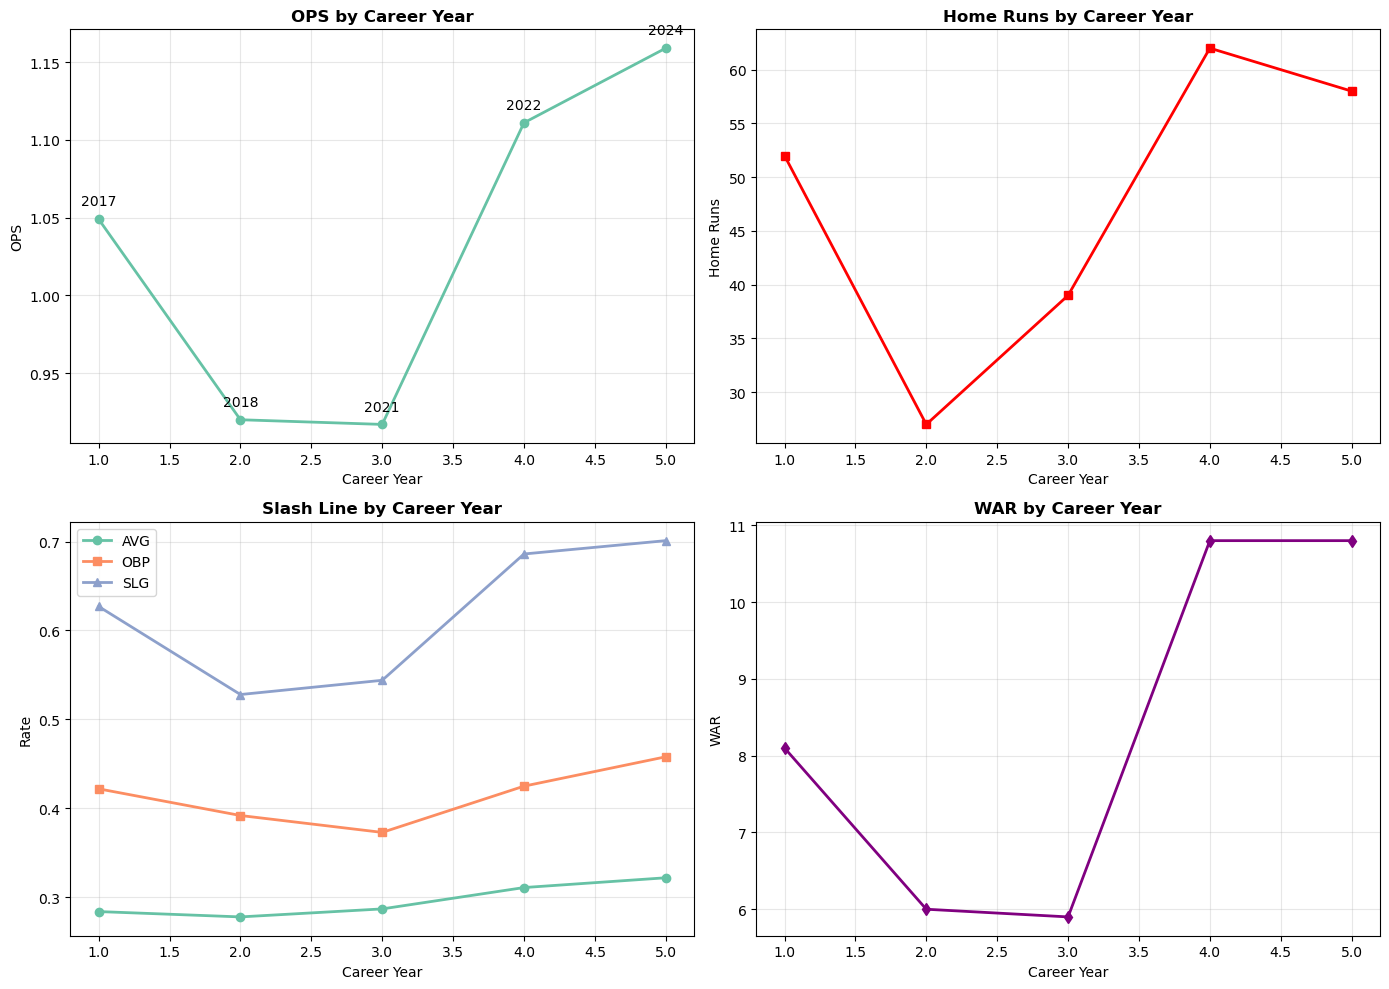


CAREER SUMMARY:
   Career Length: 5 seasons
   Peak Season: Year 5 (2024)
   Peak OPS: 1.159
   Prime Years: Around Year 4 (2022)
   Career Pattern: Late bloomer with 7.9% improvement in latter half


In [4]:
analyze_career_progression('Aaron Judge')


PLAYER COMPARISON: Shohei Ohtani vs Aaron Judge
Shohei Ohtani seasons: 2021, 2022, 2023, 2024
Aaron Judge seasons: 2017, 2018, 2021, 2022, 2024

CAREER TOTALS COMPARISON:
Metric          Shohei Ohtani   Aaron Judge     Winner    
-----------------------------------------------------------------
Games           606             730             Aaron Judge
Hits            646             784             Aaron Judge
HR              178             238             Aaron Judge
RBI             420             554             Aaron Judge
Walks           340             522             Aaron Judge
SB              116             47              Shohei Ohtani
AVG             0.286           0.298           Aaron Judge

CAREER AVERAGES COMPARISON:
Metric          Shohei Ohtani   Aaron Judge     Winner    
-----------------------------------------------------------------
Batting Avg     0.286           0.296           Aaron Judge
On-Base %       0.382           0.414           Aaron Judge
Sluggin

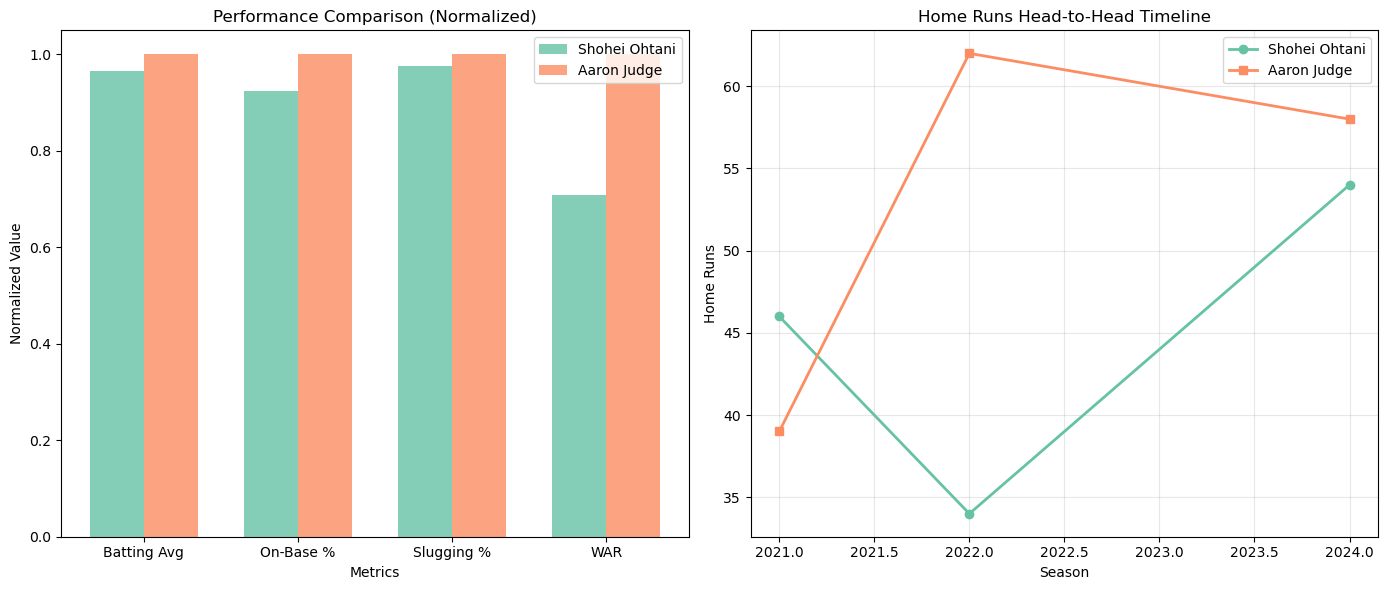

In [5]:
compare_players('Shohei Ohtani', 'Aaron Judge')

In [6]:
season_leaders(season=2023, category='batting_average')


SEASON LEADERS: Batting Average (2023)
Seasons covered: 2023
Note: Qualified hitters only (minimum 502 plate appearances)
Rank  Player                    Team       Season     Batting Average
----------------------------------------------------------------------
1     Luis Arráez               MIA        2023       0.354
2     Ronald Acuña Jr.          ATL        2023       0.337
3     Freddie Freeman           LAD        2023       0.331
4     Yandy Díaz                TBR        2023       0.330
5     Corey Seager              TEX        2023       0.327
6     Cody Bellinger            CHC        2023       0.307
7     Mookie Betts              LAD        2023       0.307
8     Bo Bichette               TOR        2023       0.306
9     Shohei Ohtani             LAA        2023       0.304
10    Michael Harris II         ATL        2023       0.293
11    Bryce Harper              PHI        2023       0.293
12    William Contreras         MIL        2023       0.289
13    Masataka Y


LEAGUE TRENDS ANALYSIS: 2016-2024
LEAGUE AVERAGES BY SEASON:
Season  AVG    OBP    SLG    OPS    K%     BB%    HR    
------------------------------------------------------------
2016.0  0.271 0.337 0.455 0.792 18.9% 8.6% 3476  
2017.0  0.269 0.341 0.463 0.804 19.5% 9.1% 3634  
2018.0  0.263 0.336 0.443 0.779 19.8% 9.2% 3358  
2019.0  0.268 0.340 0.474 0.814 20.2% 9.2% 3947  
2020.0  0.261 0.340 0.451 0.790 21.5% 9.7% 1342  
2021.0  0.263 0.337 0.450 0.788 20.8% 9.2% 3672  
2022.0  0.254 0.326 0.421 0.747 20.2% 8.8% 3102  
2023.0  0.260 0.332 0.442 0.774 20.7% 9.0% 3383  
2024.0  0.254 0.324 0.423 0.747 21.2% 8.6% 3345  

LEAGUE TREND ANALYSIS:
   Batting Average: -0.0020 per season
   On-Base %: -0.0017 per season
   Slugging %: -0.0043 per season
   Strikeout Rate: +0.24% per season
   Walk Rate: -0.02% per season


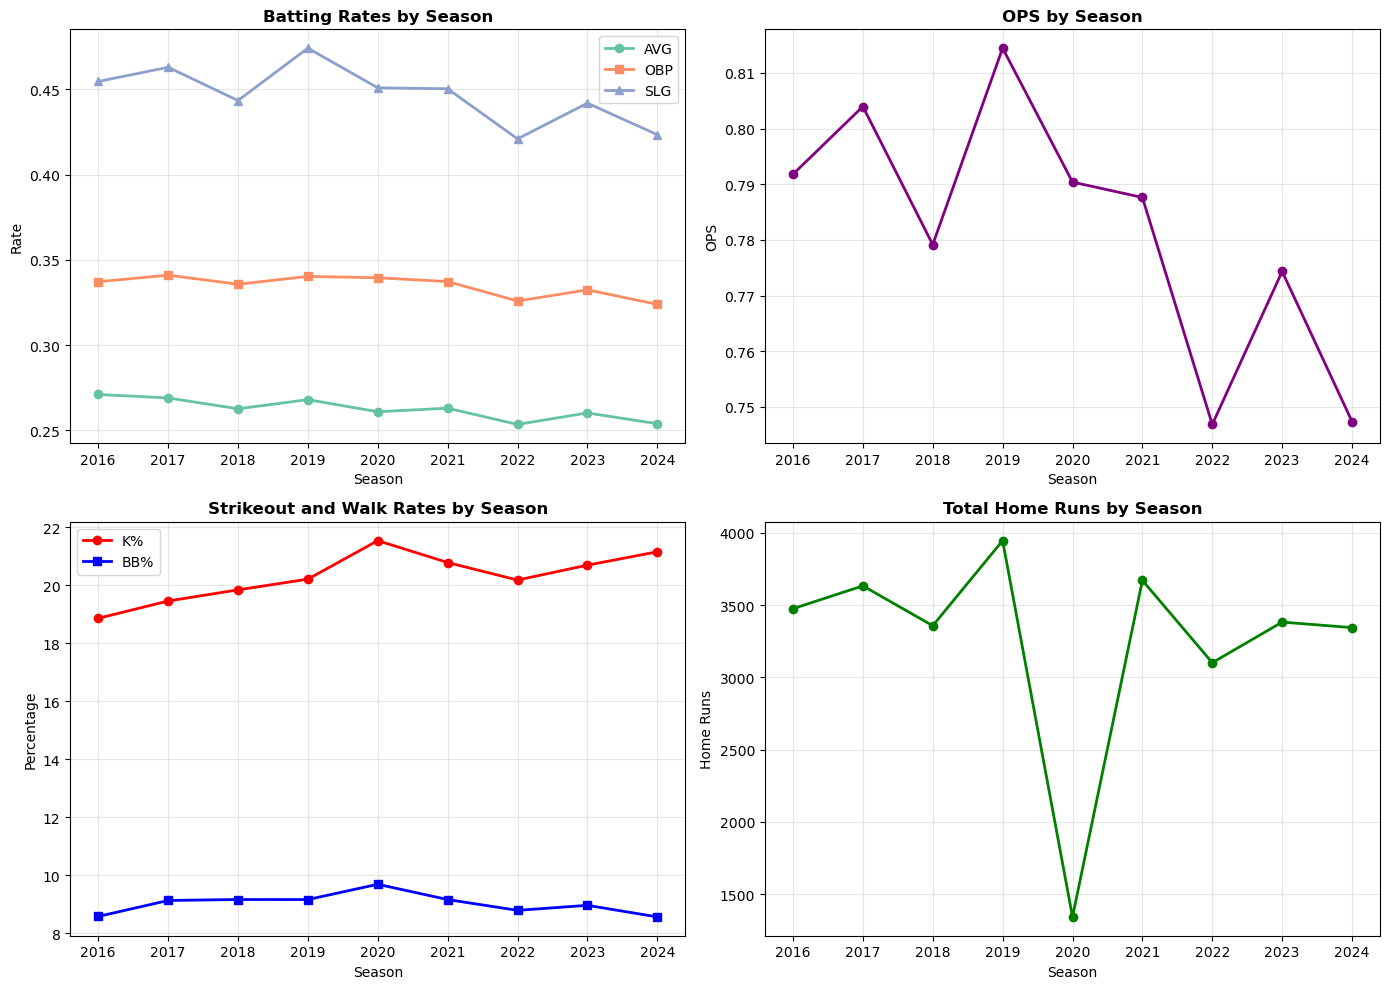


POSITION TRENDS:


In [7]:
analyze_league_trends(start_season=2016, end_season=2024)